In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm, trange

import torch
from haloflow import data as D
from haloflow import util as U

In [ ]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
if torch.cuda.is_available(): device = 'cuda:0'
else: device = 'cpu'

## read $q_\phi(Y\,|\,X)$

TNG50 mags
998 models trained
[687, 714, 589, 844, 199]
TNG50 mags_morph
1158 models trained
[848, 408, 129, 562, 150]
TNG50 mags_morph_extra
1039 models trained
[1025, 410, 890, 94, 319]
TNG100 mags
606 models trained
[327, 293, 354, 244, 568]
TNG100 mags_morph
826 models trained
[124, 762, 699, 132, 590]
TNG100 mags_morph_extra
437 models trained
[178, 116, 360, 358, 192]
TNG_ALL mags
467 models trained
[135, 145, 122, 91, 343]
TNG_ALL mags_morph
428 models trained
[235, 214, 259, 198, 153]
TNG_ALL mags_morph_extra
235 models trained
[136, 31, 96, 103, 211]
Eagle100 mags
903 models trained
[538, 312, 163, 496, 818]
Eagle100 mags_morph
1000 models trained
[706, 410, 492, 665, 725]
Eagle100 mags_morph_extra
638 models trained
[166, 550, 239, 474, 381]
Simba100 mags
1005 models trained
[594, 316, 732, 978, 915]
Simba100 mags_morph
993 models trained
[942, 891, 481, 477, 664]
Simba100 mags_morph_extra
917 models trained
[820, 330, 469, 747, 737]


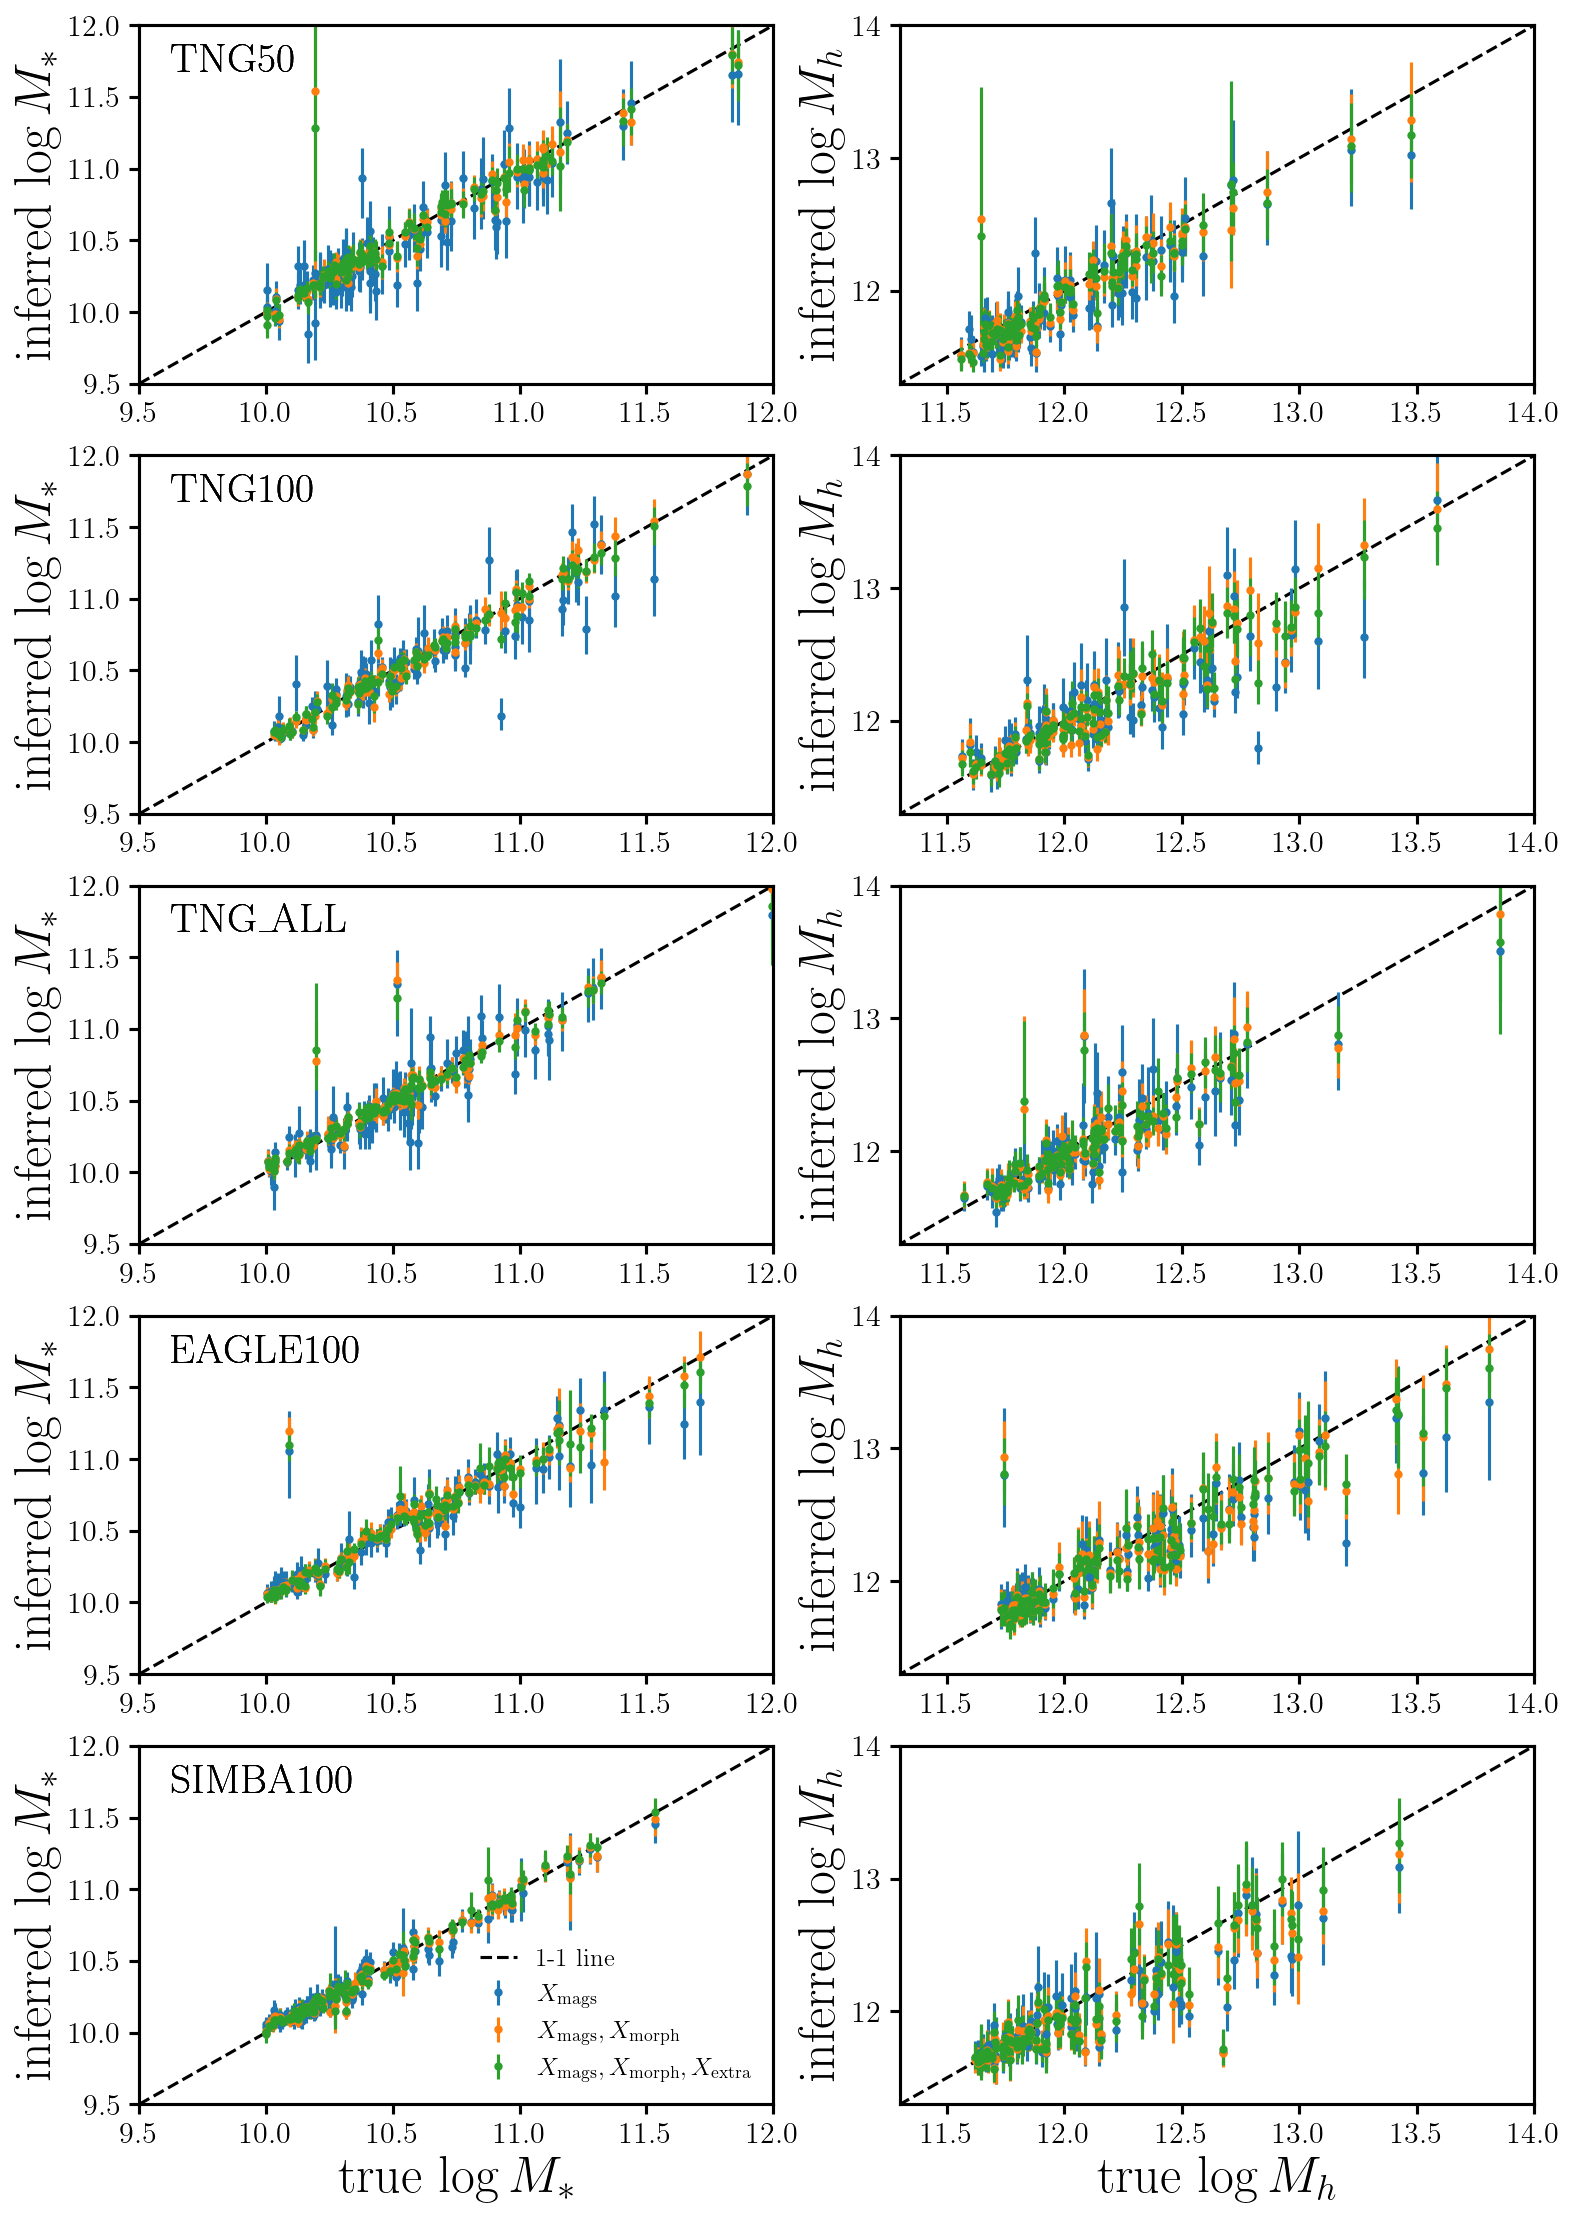

In [26]:
fig = plt.figure(figsize=(12,18), dpi=150)

sims = ['TNG50', 'TNG100', 'TNG_ALL', 'Eagle100', 'Simba100']
len_sims = len(sims)

for i_sim, sim in enumerate(sims): 
    # plot 
    sub0 = fig.add_subplot(len_sims,2,2*i_sim+1)
    sub0.plot([9.5, 12.], [9.5, 12.], c='k', ls='--')
    
    sub1 = fig.add_subplot(len_sims,2,2*i_sim+2)
    sub1.plot([9.5, 14.], [9.5, 14.], c='k', ls='--', label='_noline')

    # test-data
    Y_test, _ = D.hf2_centrals('test', 'mags_morph', sim=sim)

    igals = np.random.choice(np.arange(Y_test.shape[0]), size=100, replace=False)
    y_true = Y_test[igals]
    
    for i_obs, obs in enumerate(['mags', 'mags_morph', 'mags_morph_extra']): 
        print(sim, obs)
        # read q_phis
        qphis = U.read_best_ndes('h2.v1.%s.%s' % (sim, obs), n_ensemble=5, device=device, 
                             dat_dir='../../data/hf2/npe', verbose=True)
        Y_test, X_test = D.hf2_centrals('test', obs, sim=sim)        

        # sample NDEs
        n_sample = 1000
        y_nde = [] 
        for i in igals: 
            y_samp = []
            for qphi in qphis: 
                _samp = qphi.sample((int(n_sample/len(qphis)),),
                                       x=torch.tensor(X_test[i], dtype=torch.float32).to(device), 
                                       show_progress_bars=False)
                y_samp.append(_samp.detach().cpu().numpy())
            y_nde.append(np.concatenate(np.array(y_samp), axis=0)) 
        y_nde = np.array(y_nde)
        y_nde_q0, y_nde_q1, y_nde_q2 = np.quantile(y_nde, (0.16, 0.5, 0.84), axis=1)
    
        # plot comparison
        sub0.text(0.05, 0.95, sim.upper(), transform=sub0.transAxes, ha='left', va='top', fontsize=20)
        sub0.errorbar(y_true[:,0], y_nde_q1[:,0], 
                     yerr=[y_nde_q1[:,0] - y_nde_q0[:,0], y_nde_q2[:,0] - y_nde_q1[:,0]], fmt='.C%i' % i_obs)
        sub1.errorbar(y_true[:,1]+0.05, y_nde_q1[:,1], 
                     yerr=[y_nde_q1[:,1] - y_nde_q0[:,1], y_nde_q2[:,1] - y_nde_q1[:,1]], fmt='.C%i' % i_obs)

    sub0.set_ylabel(r'inferred $\log M_*$', fontsize=25)
    sub0.set_xlim(9.5, 12.)
    sub0.set_ylim(9.5, 12.)
    
    sub1.set_ylabel(r'inferred $\log M_h$', fontsize=25)
    sub1.set_xlim(11.3, 14.)
    sub1.set_ylim(11.3, 14.)
    
sub0.set_xlabel(r'true $\log M_*$', fontsize=25)

sub1.set_xlabel(r'true $\log M_h$', fontsize=25)

# add legend
sub0.legend(['1-1 line', '$X_{\\rm mags}$', '$X_{\\rm mags}, X_{\\rm morph}$', '$X_{\\rm mags}, X_{\\rm morph}, X_{\\rm extra}$'], loc='lower right', fontsize=12, frameon=False, ncol=1, handlelength=1.5)
